In [2]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 26.1 MB/s eta 0:00:00


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import re
import os
import time
import shutil
import pathlib
import itertools
import pickle
import numpy as np
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, BatchNormalization, Bidirectional, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Activation, Flatten, Reshape, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from textwrap import wrap
import warnings
import cv2
import matplotlib.patches as patches
import random
from IPython.display import Image
from gensim.models import Word2Vec
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import gc
import requests
from io import BytesIO
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from datasets import load_dataset 
import transformers
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
import albumentations as A
import json
from PIL import Image
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
nltk.download('wordnet')
nltk.download('omw-1.4')
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# read csv
df_train = pd.read_csv('/kaggle/input/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = 'radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [10]:
df_train.head()

id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple air levels at t...

In [11]:
df_train.isnull().sum() 
df_train.dropna(inplace=True)  

<Axes: xlabel='caption_length', ylabel='Count'>

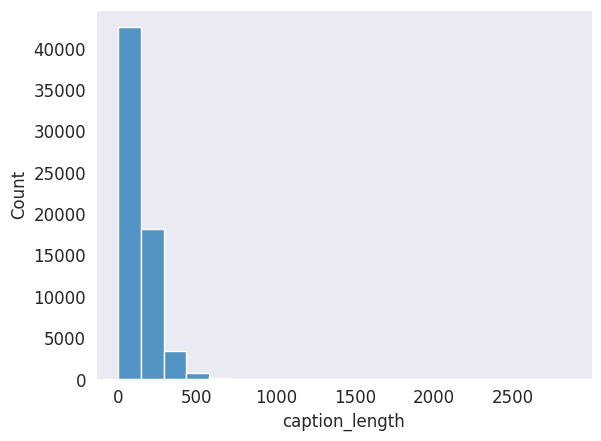

In [12]:
df_train['caption_length'] = df_train['caption'].apply(len) 
sns.histplot(df_train['caption_length'], bins=20)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.replace('\n', ' ')
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [ ]:
# Preprocess captions and store in a new column 'caption_text'
df_train['caption_text'] = df_train['caption'].apply(preprocess_text)

In [18]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption_text'].str.contains('chest xray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

id                                        name  \
69   ROCO_00087            PMC5144533_IJCCM-20-677-g002.jpg   
90   ROCO_00110              PMC4929806_CCR3-4-682-g003.jpg   
141  ROCO_00172               PMC4863054_ir-14-187-g002.jpg   
180  ROCO_00232            PMC4093973_IJCIIS-4-186-g001.jpg   
215  ROCO_00274  PMC5616218_cureus-0009-00000001523-i01.jpg   

                                               caption  caption_length  \
69    Chest X-ray, which confirmed the position of ...             129   
90         Neonatal chest X‐ray of the larger fetus.\n              43   
141   Chest X-ray findings. Chest radiograph reveal...             206   
180   Chest X-ray, PA, showing the position of the ...              56   
215    Chest x-ray showing right-sided pneumothorax.\n              47   

                                          caption_text  
69   chest xray confirm posit guidewir extend right...  
90                       neonat chest xray larger fetu  
141  chest xray find chest radiograph reveal engorg...  
180                  chest xray pa show posit gun nail  
215              chest xray show rightsid pneumothorax

In [19]:
# Create a new column 'images' by concatenating a path with the 'name' column
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']
filtered_df.head()

id                                        name  \
69   ROCO_00087            PMC5144533_IJCCM-20-677-g002.jpg   
90   ROCO_00110              PMC4929806_CCR3-4-682-g003.jpg   
141  ROCO_00172               PMC4863054_ir-14-187-g002.jpg   
180  ROCO_00232            PMC4093973_IJCIIS-4-186-g001.jpg   
215  ROCO_00274  PMC5616218_cureus-0009-00000001523-i01.jpg   

                                               caption  caption_length  \
69    Chest X-ray, which confirmed the position of ...             129   
90         Neonatal chest X‐ray of the larger fetus.\n              43   
141   Chest X-ray findings. Chest radiograph reveal...             206   
180   Chest X-ray, PA, showing the position of the ...              56   
215    Chest x-ray showing right-sided pneumothorax.\n              47   

                                          caption_text  \
69   chest xray confirm posit guidewir extend right...   
90                       neonat chest xray larger fetu   
141  chest xray find chest radiograph reveal engorg...   
180                  chest xray pa show posit gun nail   
215              chest xray show rightsid pneumothorax   

                                                images  
69   /kaggle/input/roco-dataset/all_data/train/radi...  
90   /kaggle/input/roco-dataset/all_data/train/radi...  
141  /kaggle/input/roco-dataset/all_data/train/radi...  
180  /kaggle/input/roco-dataset/all_data/train/radi...  
215  /kaggle/input/roco-dataset/all_data/train/radi...

In [20]:
folder_path = "/kaggle/working/train"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [21]:
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    shutil.copy(source_file, folder_path)

In [22]:
filtered_df = filtered_df.drop(columns=["images", "id","caption_length"])
filtered_df = filtered_df.drop(columns=["caption"])
# Create a list of dictionaries with 'file_name' and 'text' from the remaining DataFrame
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption_text"]}, axis=1).tolist()

In [23]:
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))
# Load dataset from an image folder directory for the training split
dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
dataset

Resolving data files:   0%|          | 0/1781 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 1780
})

girl chest xray film done admiss hospit show increas bilater infiltr lung done admiss


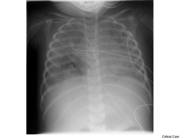

In [24]:
#display sample image
example = dataset[0]
image = example["image"]
width, height = image.size
print(example["text"])
display(image.resize((int(0.3*width), int(0.3*height))))

In [25]:
# Image Captioning
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [26]:
# Load AutoProcessor for preprocessing text and AutoModelForCausalLM for language modeling
processor = AutoProcessor.from_pretrained("microsoft/git-large-textcaps")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-textcaps")

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [27]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [28]:
#  Access and print shapes of data items from the first item in train_datase
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [29]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [30]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
# Model and calculate loss
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


tensor(12.1398, grad_fn=<NllLossBackward0>)

In [31]:
!pip install efficientnet_pytorch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=50f5056e4a0f27c2db6cf764c8f2f00ac9795dd74407f787d4fd02335411521c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [32]:
# define optimizer and set model in training mode and run training loop for 5 epochs
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
for epoch in range(5):
    print("Epoch:", epoch)
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False)
    for idx, batch in enumerate(progress_bar):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_postfix(loss=loss.item())  # Update progress bar
    print("Loss:", loss.item())

Epoch: 0


Epoch 0:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Epoch 0:   0%|          | 1/890 [00:01<20:18,  1.37s/it, loss=12.2]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 2/890 [00:01<11:59,  1.23it/s, loss=10.5]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 3/890 [00:02<09:20,  1.58it/s, loss=10.1]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 4/890 [00:02<08:02,  1.83it/s, loss=9.82]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   1%|          | 5/890 [00:03<07:19,  2.01it/s, loss=9.48]Unused or unreco

Loss: 0.16177116334438324
Epoch: 1


Epoch 1:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 1/890 [00:00<06:06,  2.43it/s, loss=0.104]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 2/890 [00:00<06:08,  2.41it/s, loss=0.0826]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 3/890 [00:01<06:05,  2.43it/s, loss=0.0588]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 4/890 [00:01<06:04,  2.43it/s, loss=0.0653]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   1%|          | 5/890 [00:02<06:06,  2.42it/s, loss=0.0999]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   1%|          | 6/890 [00:02<06:06,  2.41it/s, loss=0.0505]Unused or unrecognized kwargs: padding.
Unused or unrecogni

Loss: 0.09834200143814087
Epoch: 2


Epoch 2:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 1/890 [00:00<06:14,  2.37it/s, loss=0.16]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 2/890 [00:00<06:09,  2.40it/s, loss=0.0689]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 3/890 [00:01<06:07,  2.42it/s, loss=0.063] Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 4/890 [00:01<06:04,  2.43it/s, loss=0.197]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   1%|          | 5/890 [00:02<06:04,  2.43it/s, loss=0.16] Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   1%|          | 6/890 [00:02<06:03,  2.43it/s, loss=0.0865]Unused or unrecognized kwargs: padding.
Unused or unrecognized

Loss: 0.11207632720470428
Epoch: 3


Epoch 3:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 1/890 [00:00<06:04,  2.44it/s, loss=0.0497]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 2/890 [00:00<06:06,  2.43it/s, loss=0.0661]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 3/890 [00:01<06:05,  2.42it/s, loss=0.0635]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 4/890 [00:01<06:05,  2.43it/s, loss=0.104] Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   1%|          | 5/890 [00:02<06:04,  2.43it/s, loss=0.175]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   1%|          | 6/890 [00:02<06:00,  2.45it/s, loss=0.0299]Unused or unrecognized kwargs: padding.
Unused or unrecogni

Loss: 0.03867390379309654
Epoch: 4


Epoch 4:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 1/890 [00:00<06:10,  2.40it/s, loss=0.0269]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 2/890 [00:00<06:05,  2.43it/s, loss=0.0855]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 3/890 [00:01<06:07,  2.41it/s, loss=0.0831]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 4/890 [00:01<06:07,  2.41it/s, loss=0.0523]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   1%|          | 5/890 [00:02<06:06,  2.41it/s, loss=0.0609]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   1%|          | 6/890 [00:02<06:06,  2.41it/s, loss=0.0439]Unused or unrecognized kwargs: padding.
Unused or unrecogn

Loss: 0.05623353645205498


In [33]:
saved_folder_path = "/kaggle/working/saved_model"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)
processor.save_pretrained(saved_folder_path)
model.save_pretrained(saved_folder_path)

In [34]:
# Loading pretrained model
load_model = AutoModelForCausalLM.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

In [35]:
# Test Dataset
df_test = pd.read_csv('/kaggle/input/roco-dataset/all_data/test/radiology/testdata.csv', delimiter=',')
mask = df_test['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_test[mask]
filtered_df.head()
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']
filtered_df.head()
folder_path = "/kaggle/working/test"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    shutil.copy(source_file, folder_path)

In [36]:
filtered_df = filtered_df.drop(columns=["images", "id"])
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))
test_dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
test_dataset

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 199
})

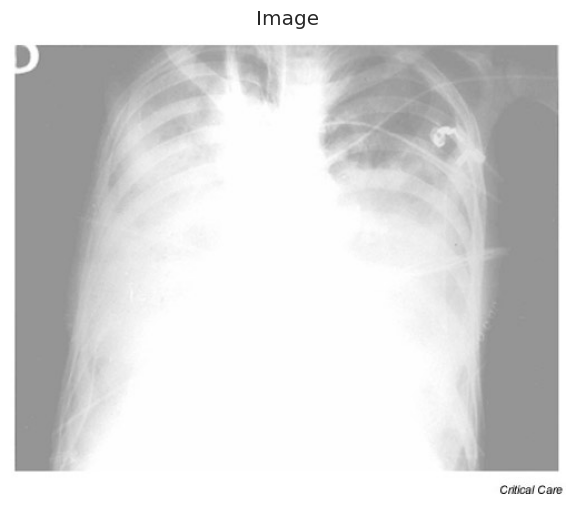

Generated Caption: chest xray show bilater pleural effus


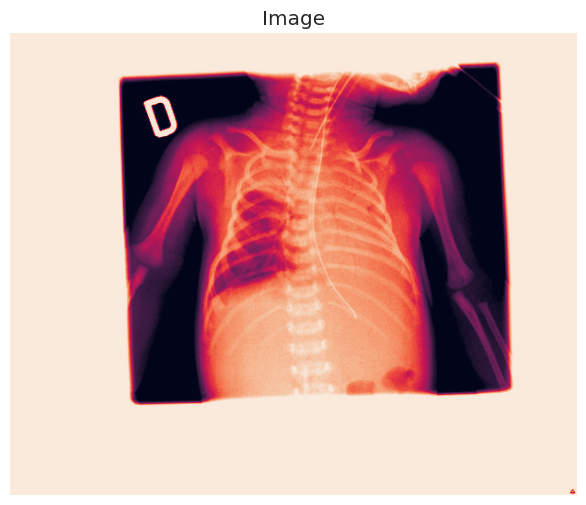

Generated Caption: chest xray show left side pleural effus


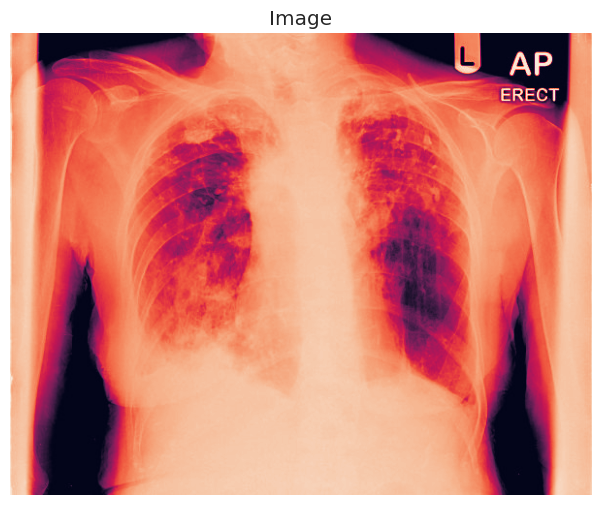

Generated Caption: chest xray show bilater pleural effus


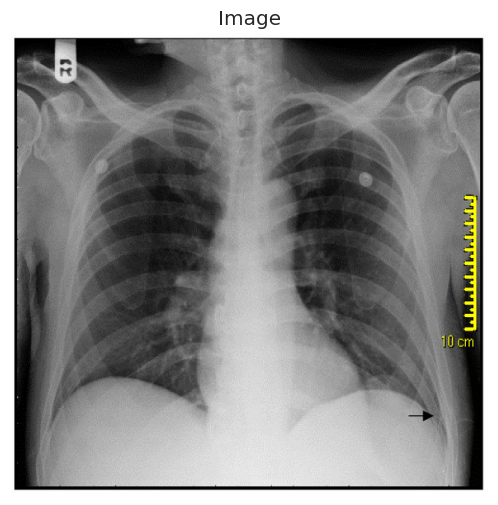

Generated Caption: chest xray show bilater interstiti lung mark


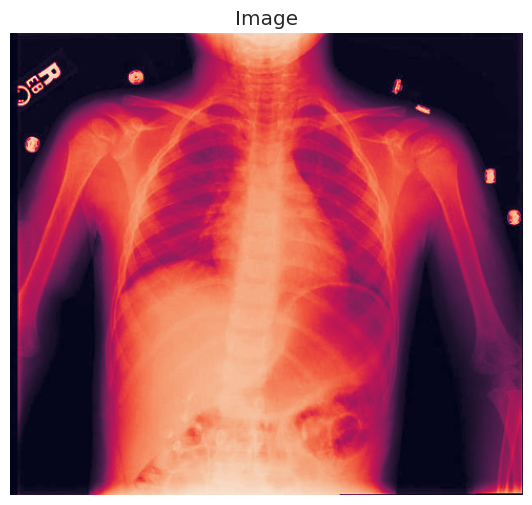

Generated Caption: chest xray show left side pleural effus


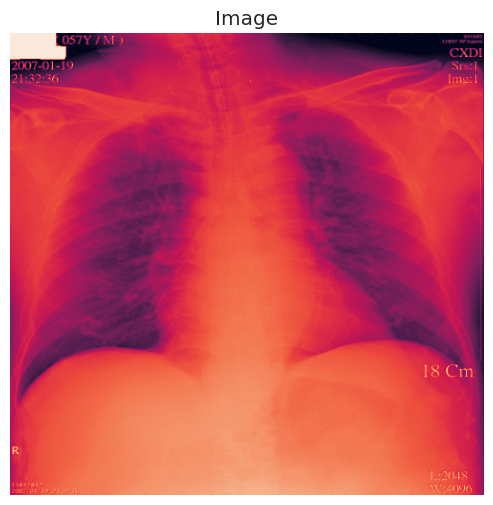

Generated Caption: chest xray show bilater pleural effus


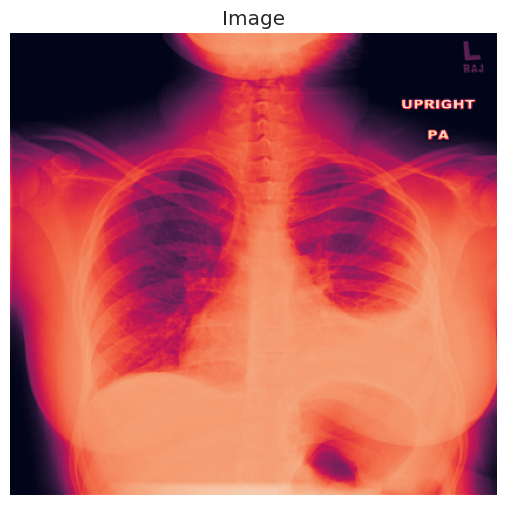

Generated Caption: chest xray show left side pleural effus


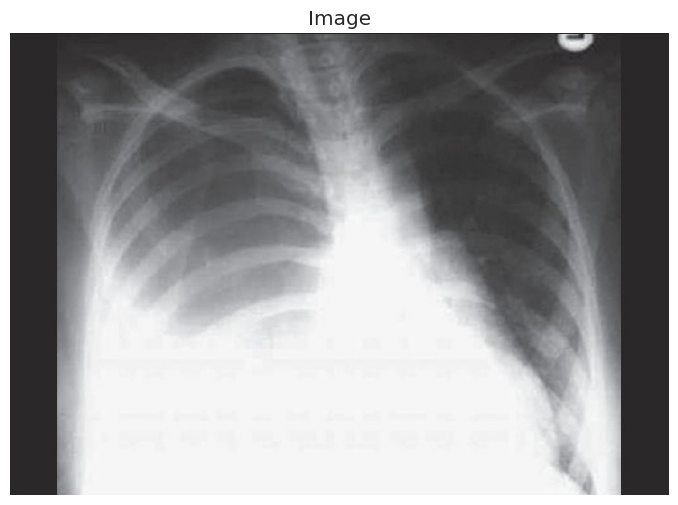

Generated Caption: chest xray show bilater pleural effus


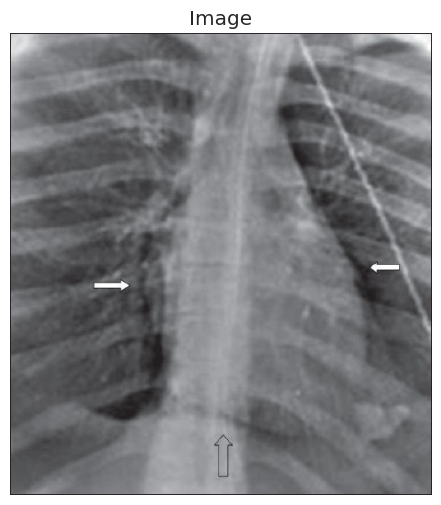

Generated Caption: chest xray show left side pleural effus


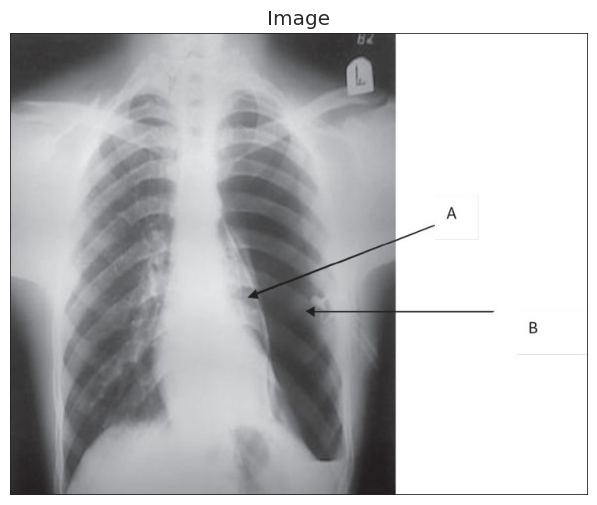

Generated Caption: chest xray show left side pleural effus


In [37]:
# Iterate through a subset of test_dataset, generate captions for images using a pretrained model,
# and display each image with its corresponding generated caption.
count = 0
for example in test_dataset:
    if count == 10:
        break  
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    fig = plt.figure(figsize=(12, 6))  
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image") 
    plt.show()
    print("Generated Caption:", generated_caption)
    count += 1  


Model 2

In [39]:
image_path = '/kaggle/input/roco-dataset/all_data/train/radiology/images'

In [40]:
# mask = df_train['caption_text'].str.contains('xray', case=False)
filtered_df2 = df_train.sample(n=15000, random_state=42) 
filtered_df2 = filtered_df2.drop(columns=[ "id","caption_length","caption"])
data=filtered_df2

In [41]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.    
    return img
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/roco-dataset/all_data/train/radiology/images/{temp_df.name[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption_text[i], 20)))
        plt.axis("off")

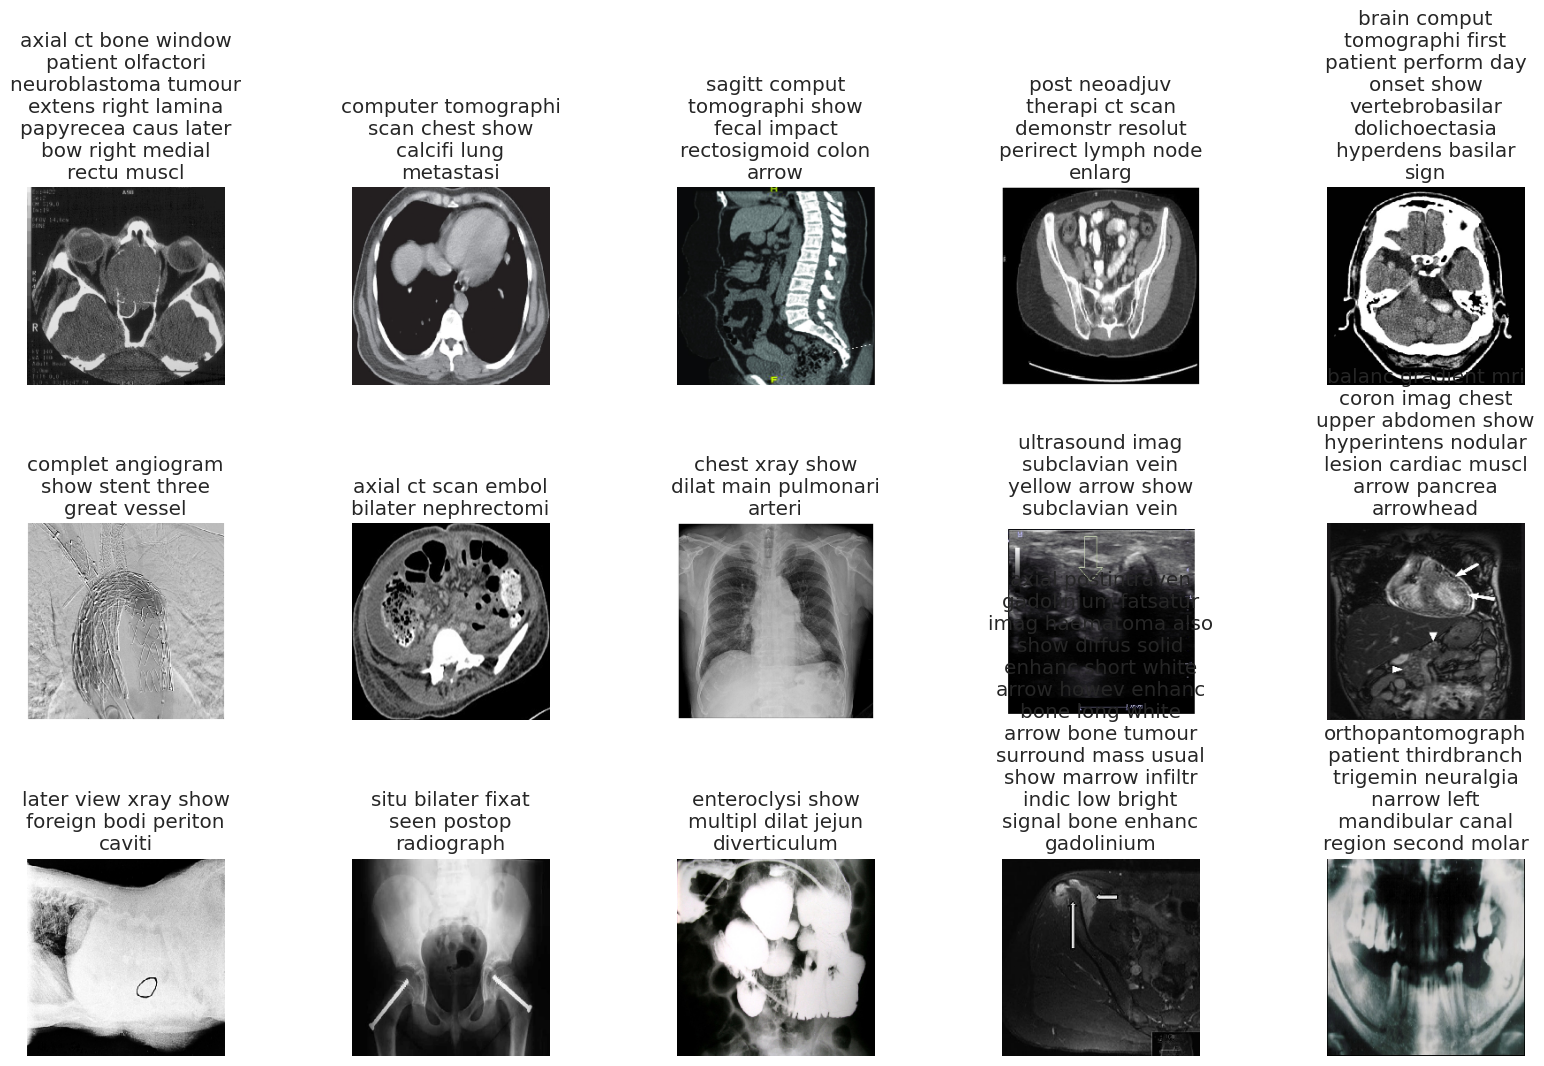

In [42]:
display_images(data.sample(15))

In [43]:
# text preprocessing
def text_preprocessing(data):
    data['caption_text'] = data['caption_text'].apply(lambda x: x.lower())
    data['caption_text'] = data['caption_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # Using regex for replacing non-alphabetic characters
    data['caption_text'] = data['caption_text'].apply(lambda x: re.sub(r'\s+', ' ', x))  # Replace multiple spaces with single space
    data['caption_text'] = data['caption_text'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))  # Remove single character words
    data['caption_text'] = "startseq " + data['caption_text'] + " endseq"  # Adding startseq and endseq tokens
    return data

In [44]:
# Preprocess text data and retrieve caption texts as a list
data = text_preprocessing(data)
captions = data['caption_text'].tolist()
captions[:10]

['startseq brain ct scan show epidur hematoma contus right tempor region endseq',
 'startseq initi iliac crest bone harvest procedur postop radiograph demonstr rel posit incis closur stapl endseq',
 'startseq demonstr larg locul rim enhanc right retroperiton fluid collect arrow endseq',
 'startseq bedsid ultrasound demonstr hyperecho object within bladder endseq',
 'startseq imag echo imag modifi parastern long axi view show ventricular noncompact rv right ventricl ventricular noncompact endseq',
 'startseq chest ct imag patient endseq',
 'startseq radiographi postopratoir apr laminectomi dcompress et stabilis du rachi dorsal par instrument postrieur endseq',
 'startseq background elimin red channel de rgb space endseq',
 'startseq cm nodular lesion left lower pole kidney arrow endseq',
 'startseq grayscal ultrasonographi patient transplant kidney month surgeri endseq']

In [45]:
# Initialize tokenizer, fit on captions, determine vocabulary size and max sequence length,
# split data into train and test sets based on image names, and convert captions to sequences.
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
images = data['name'].unique().tolist()
nimages = len(images)
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]
train = data[data['name'].isin(train_images)]
test = data[data['name'].isin(val_images)]
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 196, 253, 1150, 38, 3186, 551, 51, 10, 19, 632, 99, 1587, 1064, 2091, 2]

In [46]:

# Extract features from images using DenseNet201 pretrained on ImageNet,
# and store the features in a dictionary indexed by image names.
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
img_size = 224
features = {}
for image in tqdm(data['name'].unique().tolist()):
    try:
        img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.
        img = np.expand_dims(img, axis=0)
        feature = fe.predict(img, verbose=0)
        features[image] = feature
    except FileNotFoundError:
        pass

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


  0%|          | 0/15000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1720122643.955480     460 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 15000/15000 [22:58<00:00, 10.88it/s]


In [47]:


#  Custom data generator for training neural networks with image features and captions.

class CustomDataGenerator(Sequence):  
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):   
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)      
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)    
    def __len__(self):
        return self.n // self.batch_size    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y   
    def __get_data(self, batch):
        X1, X2, y = [], [], []
        
        for _, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]         
            try:
                if image in self.features:
                    feature = self.features[image][0]
                    seq = self.tokenizer.texts_to_sequences([caption])[0]              
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)
                else:
                    print(f"Warning: Feature vector for image {image} not found. Skipping this sample.")          
            except KeyError:
                print(f"Warning: Image {image} not found in features. Skipping this sample.")
                continue        
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y

In [48]:
# Define a neural network model for image captioning
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [49]:
# Summary
from tensorflow.keras.utils import plot_model
caption_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 205)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 205, 256)  │  3,497,472 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 206, 256)  │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 13662)     │  1,762,398 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,309,854 (24.07 MB)

 Trainable params: 6,309,854 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:

train_generator = CustomDataGenerator(
    df=train,
    X_col='name',  
    y_col='caption_text',  
    batch_size=64,
    directory=image_path, 
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features  
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='name',  
    y_col='caption_text',  
    batch_size=64,
    directory=image_path, 
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features  
)


In [51]:
# Define callbacks/checkpoints for model training.
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [52]:
# Train the captioning model using generator data for 50 epochs,with validation on a separate generator and callbacks for checkpointing,early stopping, and learning rate reduction.
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
 21/199 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - loss: 8.7974Warning: Feature vector for image PMC2946122_yjbm_83_3_113_g01.jpg not found. Skipping this sample.
 32/199 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - loss: 8.5251Warning: Feature vector for image PMC3999928_f1000research-3-4060-g0002.jpg not found. Skipping this sample.
 34/199 ━━━━━━━━━━━━━━━━━━━━ 35s 216ms/step - loss: 8.4863Warning: Feature vector for image PMC2892771_yjbm_83_2_67_g01.jpg not found. Skipping this sample.
 88/199 ━━━━━━━━━━━━━━━━━━━━ 24s 216ms/step - loss: 7.9290Warning: Feature vector for image PMC4603610_amjcaserep-16-715-g002.jpg not found. Skipping this sample.
 98/199 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 7.8721Warning: Feature vector for image PMC5569400_05-i004b.jpg not found. Skipping this sample.
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 7.5252
Epoch 1: val_loss improved from inf to 6.59775, saving model to model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 256ms/step - loss: 7.5230 - 

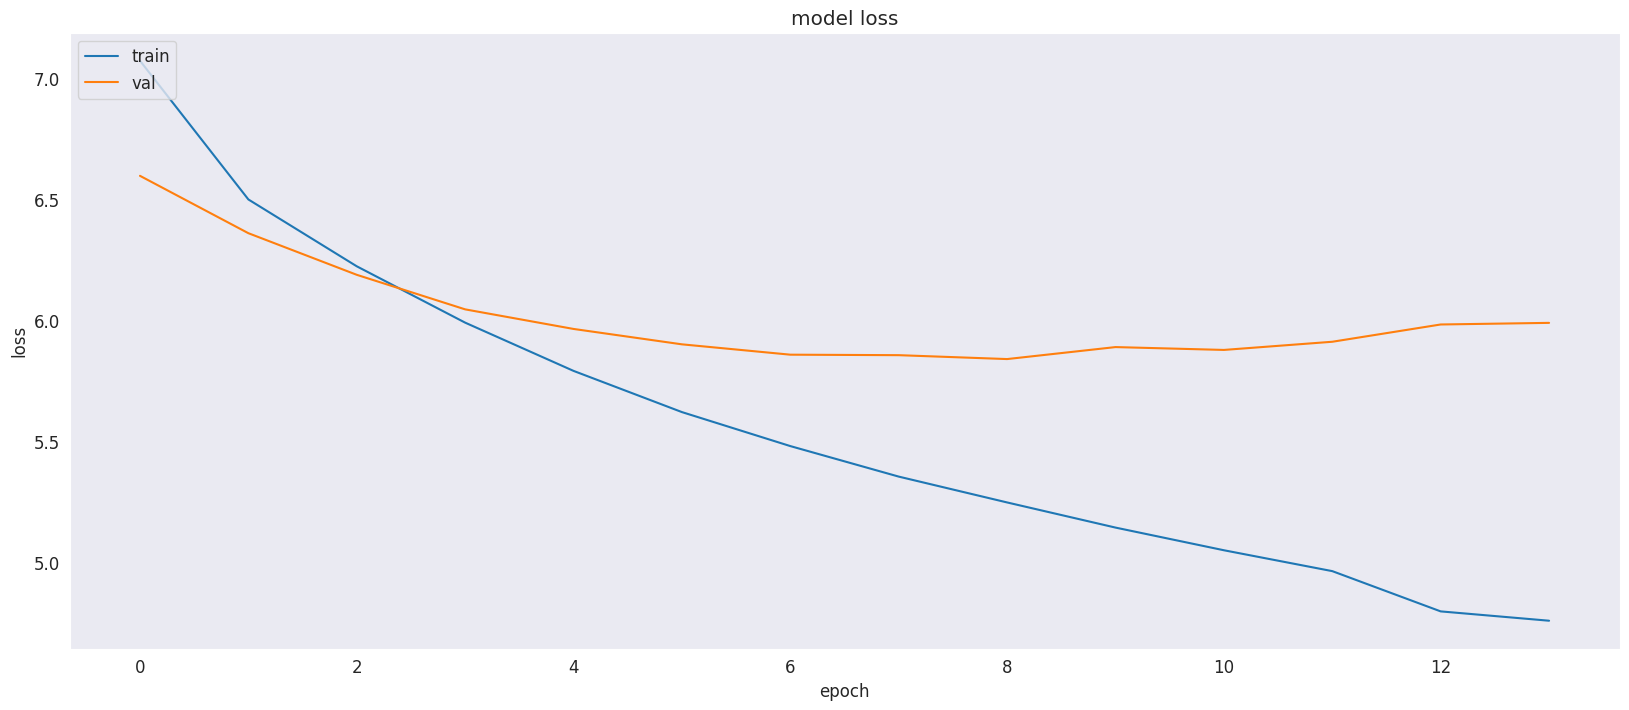

In [53]:
#plot of model loss
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
# Convert integer index to corresponding word using tokenizer's word index mapping
def idx_to_word(integer,tokenizer): 
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [55]:
# Predict Caption
def predict_caption(model, image, tokenizer, max_length, features):  
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)        
        word = idx_to_word(y_pred, tokenizer)        
        if word is None:
            break
        in_text+= " " + word
        if word == 'endseq':
            break
    return in_text 

In [56]:
# considering sample 
samples = test.sample(1500)
samples.reset_index(drop=True,inplace=True)

In [57]:
samples

name  \
0        PMC5410104_13104_2017_2494_Fig1_HTML.jpg   
1        PMC5294839_13256_2017_1215_Fig1_HTML.jpg   
2                 PMC2518549_1749-8090-3-49-1.jpg   
3                              PMC5440753_gr5.jpg   
4           PMC4492486_amjcaserep-16-424-g005.jpg   
...                                           ...   
1495                  PMC2850860_wjem-11-76f1.jpg   
1496               PMC3015265_jsls-2-1-79-g01.jpg   
1497          PMC4387938_CRIOT2015-813240.001.jpg   
1498         PMC3616177_amjcaserep-13-22-g002.jpg   
1499  PMC3959392_AnnGastroenterol-25-167-g003.jpg   

                                           caption_text  
0     startseq crop imag later cephalogram normal ce...  
1     startseq abdomin xray show diffus opaqu area u...  
2     startseq preoper aortographi show dilat ascend...  
3     startseq statist parametr map spm group effect...  
4     startseq chest ct scan perform first cours rom...  
...                                                 ...  
1495  startseq pelvic ultrasound show complex fluid ...  
1496   startseq scheme trocar placement procedur endseq  
1497   startseq mri show mass patient soft palat endseq  
1498  startseq simpl xray left hip month trauma nove...  
1499  startseq endoscop ultrasound show small ampull...  

[1500 rows x 2 columns]

In [58]:
# Generate and store predicted captions for each image in 'samples' DataFrame using a trained captioning model.
for index,record in samples.iterrows():
    img = load_img(os.path.join(image_path,record['name']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    caption = predict_caption(caption_model, record['name'], tokenizer, max_length, features)
    samples.loc[index,'predict_caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

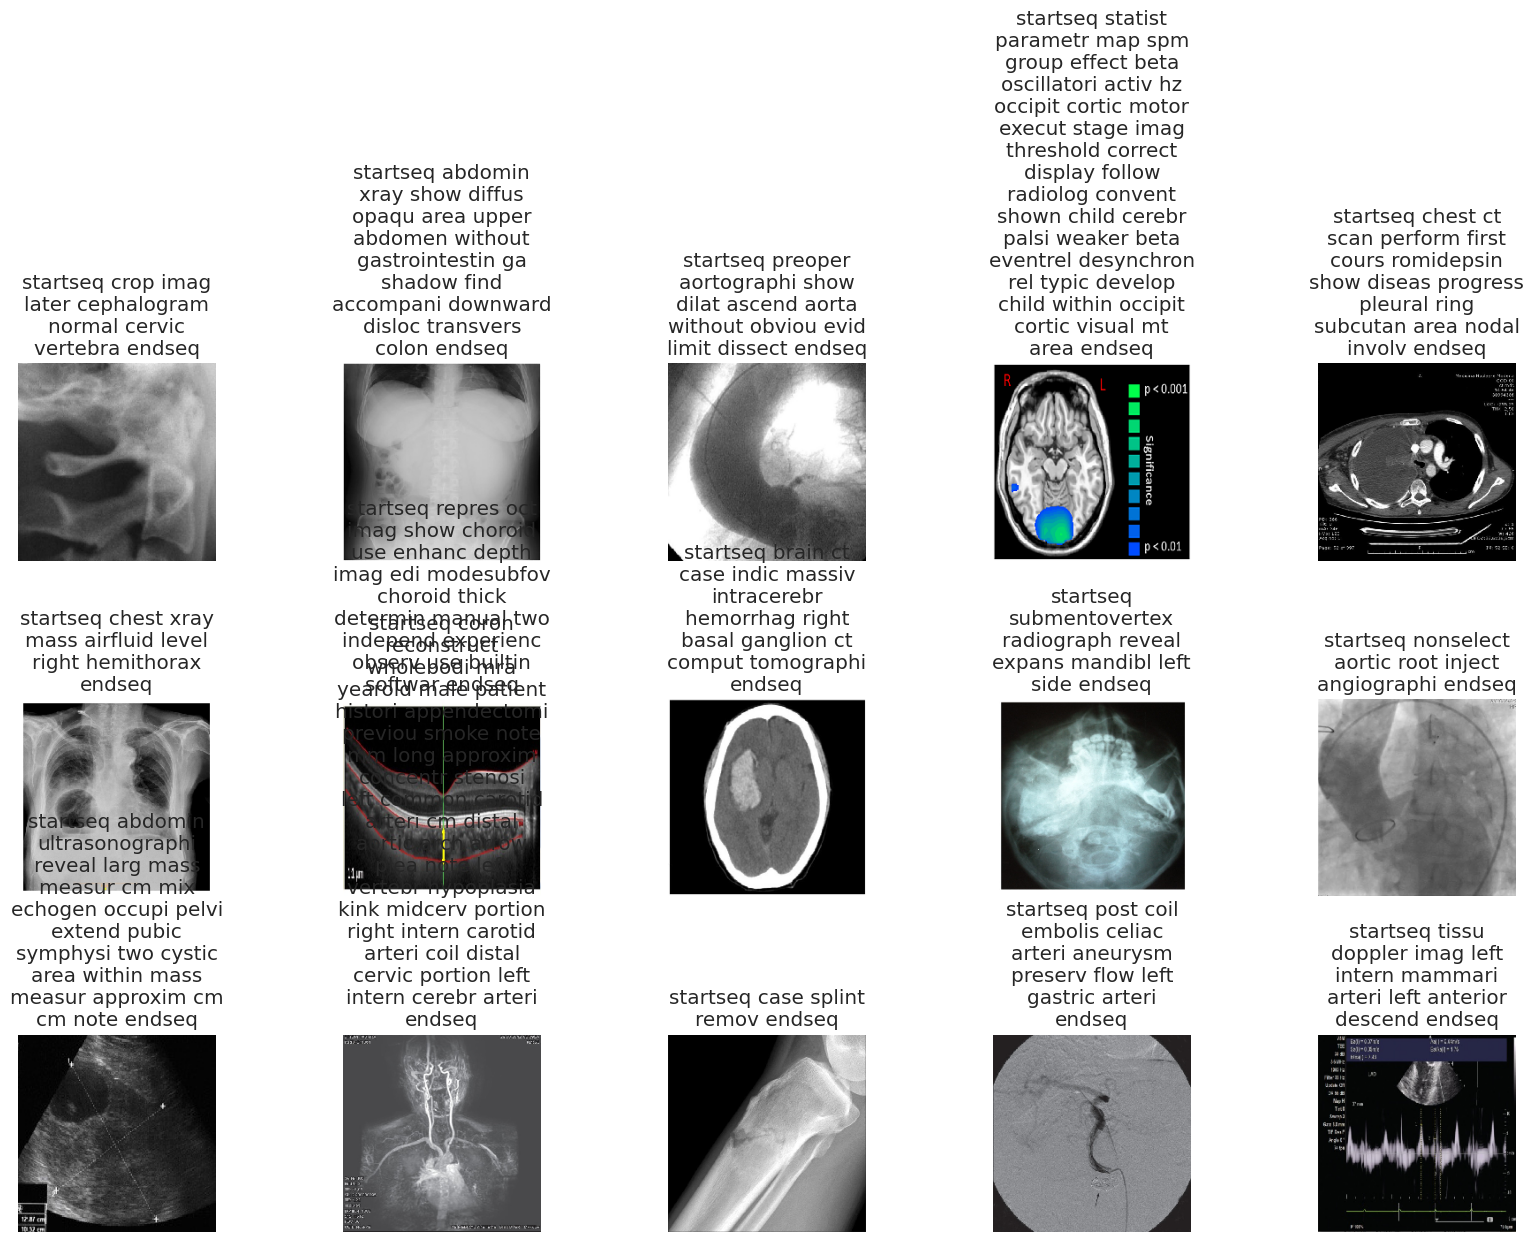

In [59]:
display_images(samples)

In [60]:
!pip install pycocoevalcap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [61]:
#calculate BLEU, METEOR, ROUGE, CIDEr
def evaluate_model(df):
    actual = df['caption_text'].apply(lambda x: x.split())
    predicted = df['predict_caption'].apply(lambda x: x.split())    
    bleu_score = calculate_bleu(actual, predicted)
    print(f"BLEU score: {bleu_score}")
    meteor_score = calculate_meteor(actual, predicted)
    print(f"METEOR score: {meteor_score}")
    rouge_score = calculate_rouge(actual, predicted)
    print(f"ROUGE score: {rouge_score}")
    cider_score = calculate_cider(actual, predicted)
    print(f"CIDEr score: {cider_score}")
def calculate_bleu(references, candidates):
    references = [[ref] for ref in references]
    smoothing_function = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothing_function)
def calculate_meteor(references, candidates):
    scorer = Meteor()
    scores, _ = scorer.compute_score({i: [' '.join(ref)] for i, ref in enumerate(references)},
                                     {i: [' '.join(can)] for i, can in enumerate(candidates)})
    return np.mean(scores)
def calculate_rouge(references, candidates):
    scorer = Rouge()
    scores, _ = scorer.compute_score({i: [' '.join(ref)] for i, ref in enumerate(references)},
                                     {i: [' '.join(can)] for i, can in enumerate(candidates)})
    return np.mean(scores)
def calculate_cider(references, candidates):
    scorer = Cider()
    scores, _ = scorer.compute_score({i: [' '.join(ref)] for i, ref in enumerate(references)},
                                     {i: [' '.join(can)] for i, can in enumerate(candidates)})
    return np.mean(scores)
evaluate_model(samples)


BLEU score: 0.016158979435927246
METEOR score: 0.09477530822472308
ROUGE score: 0.30147473694842314
CIDEr score: 0.1758353330124694


Model 3

In [4]:
BASE_DIR = '/kaggle/input/roco-dataset/all_data/train/radiology'
WORKING_DIR = '/kaggle/working/'

In [5]:
# mask = df_train['caption_text'].str.contains('xray', case=False)
filtered_df3 = df_train.sample(n=5000, random_state=42) 

NameError: name 'df_train' is not defined

In [64]:
image_names = filtered_df3['name'].tolist()

In [3]:
base_model = Xception(weights='imagenet', include_top=False) #with imagenet weights

NameError: name 'Xception' is not defined

In [66]:
#Load Xception model without the top layer and with ImageNet weights
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
model = Model(inputs=base_model.input, outputs=x)

In [67]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_1[0][0]     

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [68]:
# Initialize features dictionary, set image directory, iterate over image names to load, preprocess, predict features using Xception model, handle errors, and save features to pickle file.
features = {}
directory = os.path.join(BASE_DIR, 'images')
for img_name in tqdm(image_names):
    try:
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(299, 299))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        features[image_id] = feature
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        continue
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

 59%|█████▊    | 2928/5000 [03:35<02:09, 15.95it/s]

Error processing PMC5218828_nihms839236f3.jpg: [Errno 2] No such file or directory: '/kaggle/input/roco-dataset/all_data/train/radiology/images/PMC5218828_nihms839236f3.jpg'


100%|██████████| 5000/5000 [06:03<00:00, 13.74it/s]


In [69]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [70]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [71]:
filtered_df3.head()

id                                   name  \
18521  ROCO_23122          PMC4852590_kjn-10-31-g001.jpg   
36906  ROCO_46080    PMC5155106_CRIS2016-5365647.001.jpg   
56991  ROCO_71189                   PMC5587902_fig-2.jpg   
44087  ROCO_55036  PMC3886584_CRIM.EM2013-587018.003.jpg   
22000  ROCO_27429           PMC3663152_IPC-14-1-g002.jpg   

                                                 caption  caption_length  \
18521   Brain CT scan showing an epidural hematoma an...              88   
36906   Initial iliac crest bone harvest procedure po...             135   
56991   Demonstration of large, loculated rim enhanci...              97   
44087   Bedside ultrasound demonstrating hyperechoic ...              73   
22000   2D image echo image (modified parasternal lon...             146   

                                            caption_text  
18521  brain ct scan show epidur hematoma contus righ...  
36906  initi iliac crest bone harvest procedur postop...  
56991  demonstr larg locul rim enhanc right retroperi...  
44087  bedsid ultrasound demonstr hyperecho object wi...  
22000  imag echo imag modifi parastern long axi view ...

In [72]:
# Import tqdm, initialize mapping, iterate over rows to map image IDs to captions
from tqdm import tqdm
mapping = {}
for _, row in tqdm(filtered_df3.iterrows(), total=filtered_df3.shape[0]):
    image_id = row['name'].split('.')[0]  
    caption = row['caption']
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 5000/5000 [00:00<00:00, 16581.87it/s]


In [76]:
# Clean captions in mapping: convert to lowercase, remove non-alphabetic characters, reduce whitespace, add startseq and endseq tokens
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [77]:
# Generate Word2Vec model using all captions, set vector size, window size, and minimum count for vocabulary size calculation
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption.split())
word2vec_model = Word2Vec(all_captions, vector_size=512, window=5, min_count=1, workers=4)
vocab_size = len(word2vec_model.wv.index_to_key) + 1

In [78]:
# Initialize embedding matrix, create word index from Word2Vec model vocabulary, populate embedding matrix with word vectors
embedding_dim = 512
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

In [2]:
max_length = max(len(caption) for caption in all_captions)
max_length

NameError: name 'all_captions' is not defined

In [80]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [81]:
# data generator
def data_generator(data_keys, mapping, features, word_index, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = [word_index[word] for word in caption.split() if word in word_index]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [82]:
# modelling
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=1e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 321)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 321, 512)  │  7,332,864 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 321)       │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ input_layer_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 321, 512)  │      2,048 │ embedding_1[0][0… │
│ (BatchNormalizatio… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,049,088 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │  1,574,912 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    524,800 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 14322)     │  7,347,186 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,839,090 (68.05 MB)

 Trainable params: 10,501,106 (40.06 MB)

 Non-trainable params: 7,337,984 (27.99 MB)

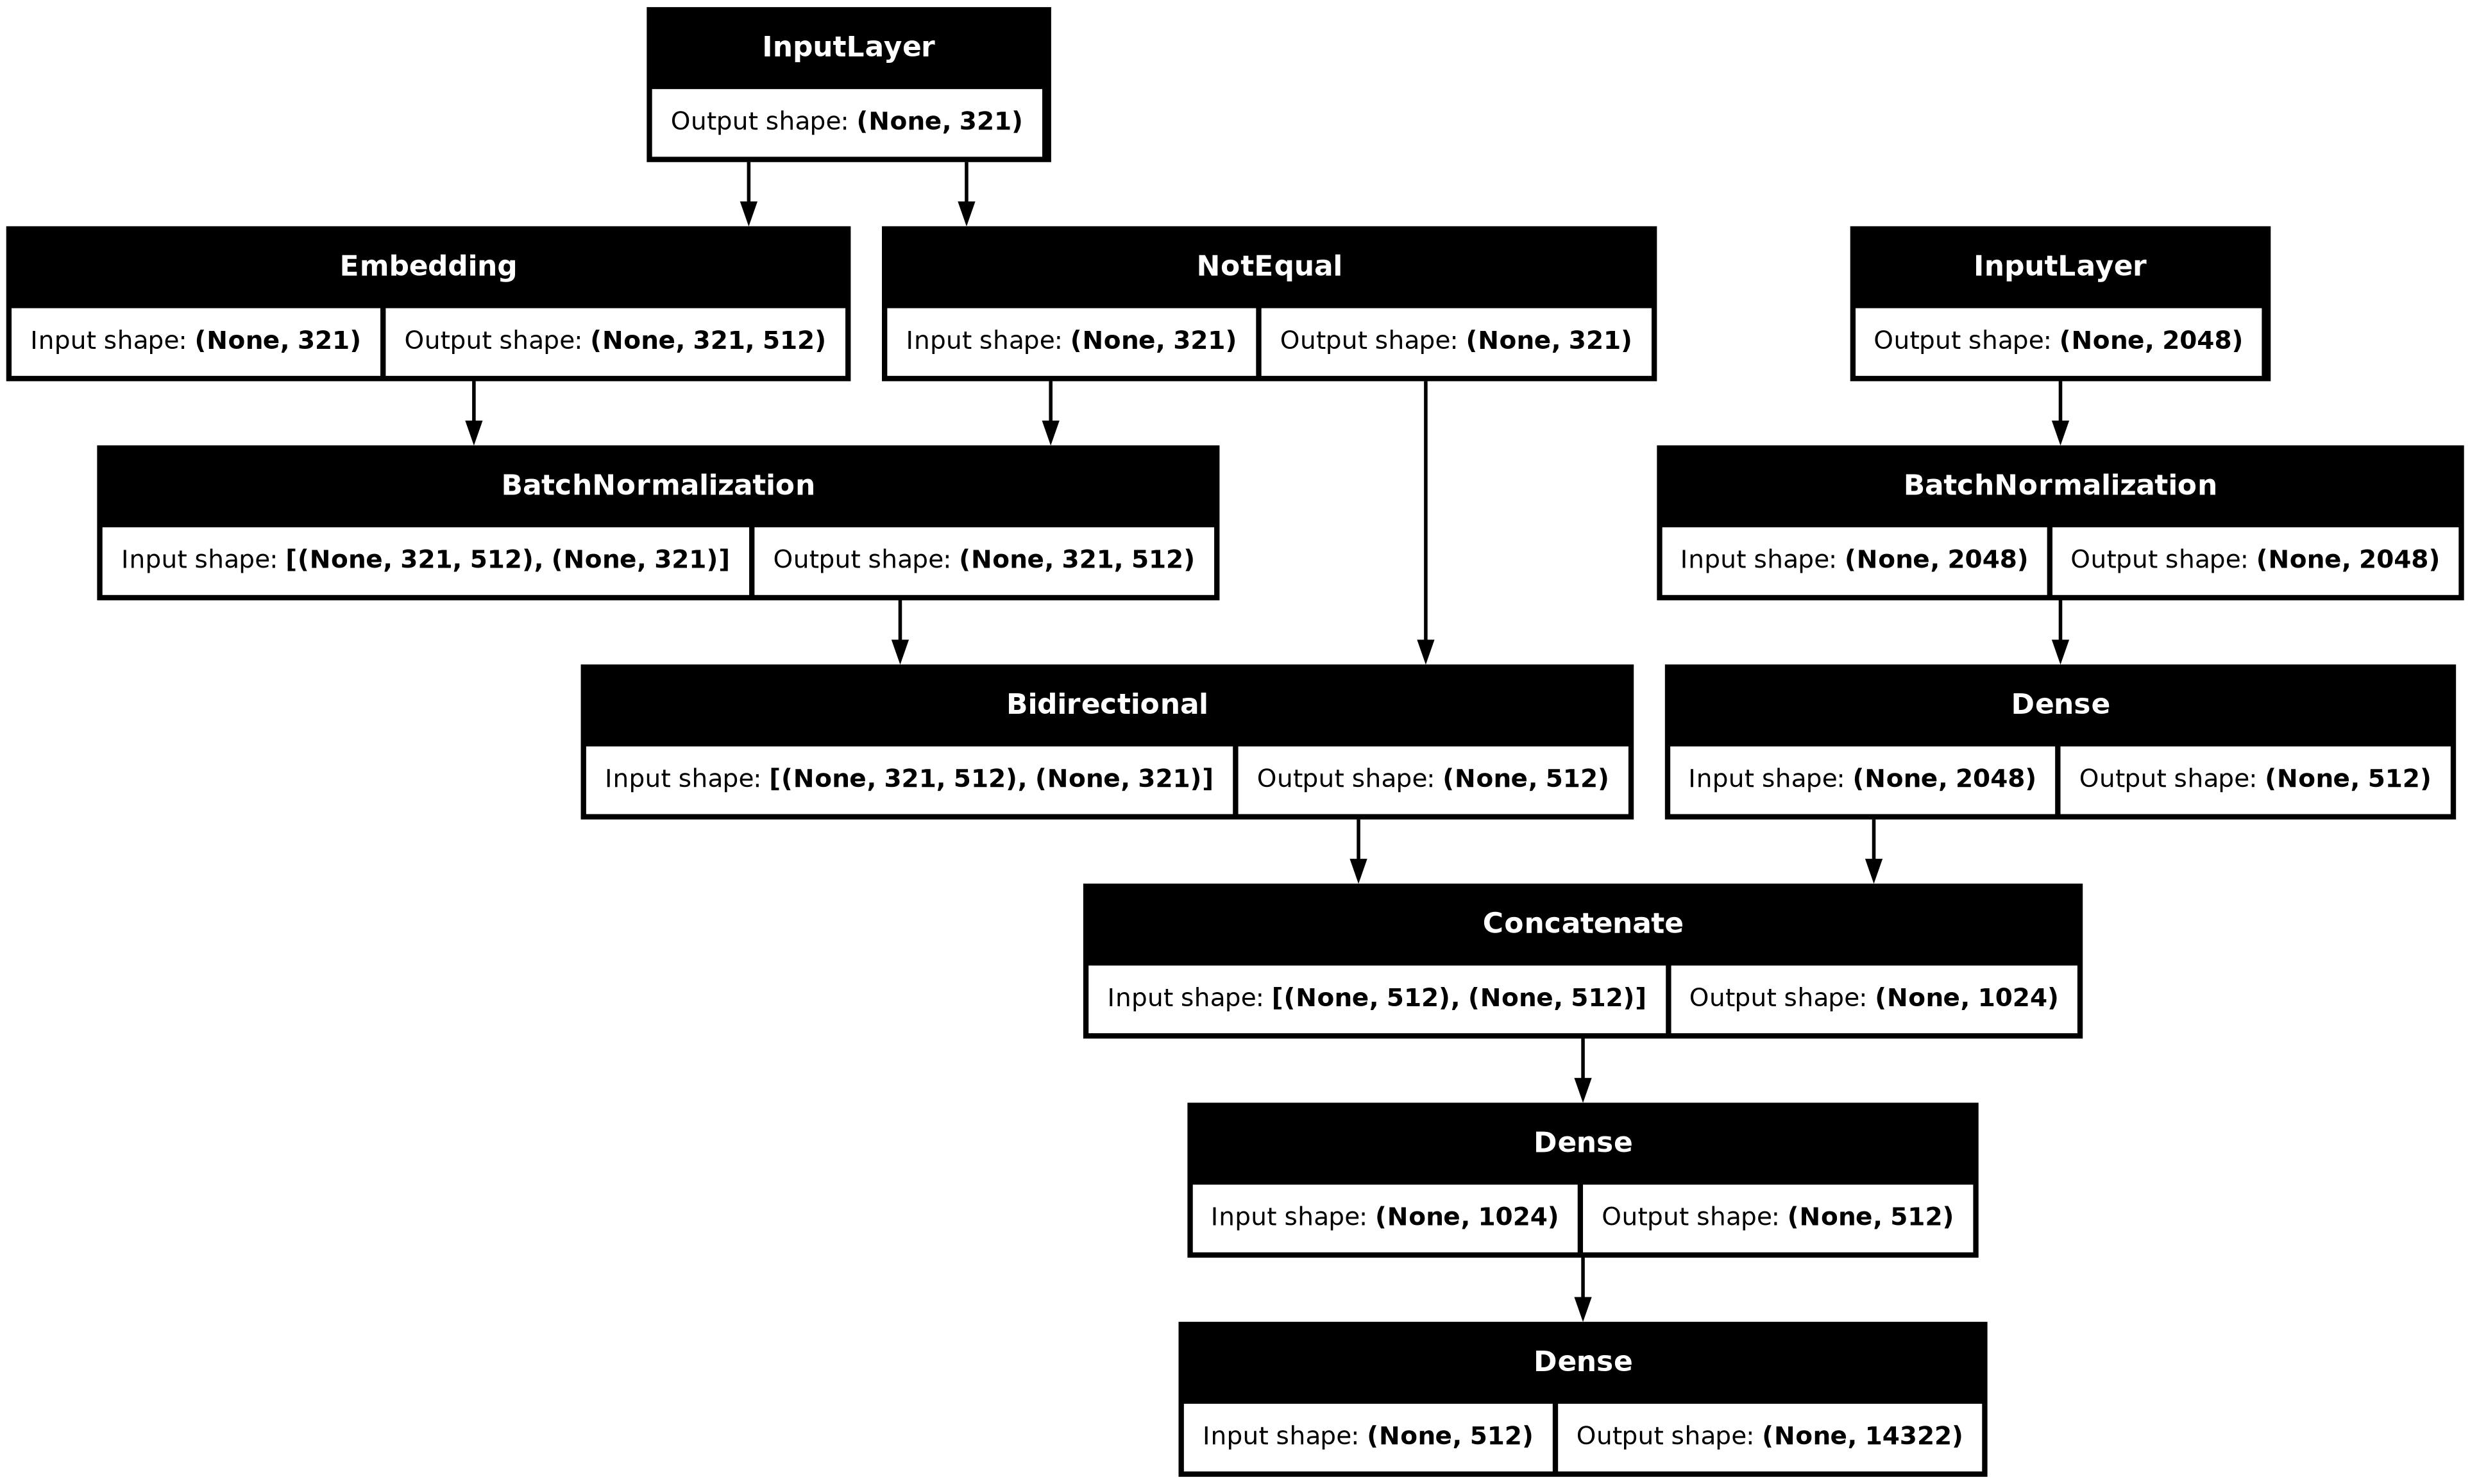

In [83]:
plot_model(model, show_shapes=True)

In [1]:
epochs = 10 
batch_size = 32
steps = len(train) // batch_size
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

NameError: name 'train' is not defined

In [85]:
for i in range(epochs):
    generator = data_generator(train, mapping, features, word_index, max_length, vocab_size, batch_size)
    try:
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[model_checkpoint_callback])
    except Exception as e:
        print(f". Skipping this epoch and continuing...")
        continue

 58/139 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.0753 - loss: 8.7985

2024-07-04 21:05:56.067093: E external/local_xla/xla/stream_executor/dnn.cc:1140] OOM when allocating tensor with shape[82565124] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...
. Skipping this epoch and continuing...


In [86]:
# Map integer to word using word_index dictionary, generate caption predictions using model, iterate until 'endseq' or max length
def idx_to_word(integer, word_index):
    for word, index in word_index.items():
        if index == integer:
            return word
    return None
def predict_caption(model, image, word_index, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[word] for word in in_text.split() if word in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, word_index)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
# calculate BLEU
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], word_index, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1, 0, 0, 0)))

  0%|          | 0/497 [00:00<?, ?it/s]

In [ ]:
model.save(WORKING_DIR + '/model.keras')

In [ ]:
# generate caption
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    if image_id not in features:
        print(f"Image ID '{image_id}' not found in features dictionary.")
        return ""
    y_pred = predict_caption(model, features[image_id], word_index, max_length)
    return y_pred.replace("startseq ", "").replace(" endseq", "")


In [ ]:
import matplotlib.patches as patches

def display_random_images_with_captions(directory, num_images=5):
    image_list = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    valid_images = [image_name for image_name in image_list if image_name.split('.')[0] in features]
    random_images = random.sample(valid_images, num_images)
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))    
    for idx, image_name in enumerate(random_images):
        image_path = os.path.join(directory, image_name)
        image_id = image_name.split('.')[0]     
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     
        axes[idx, 0].imshow(image)
        axes[idx, 0].axis('off')    
        rect = patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, edgecolor='#006600', facecolor='none')
        axes[idx, 0].add_patch(rect)      
        caption = generate_caption(image_name)
        axes[idx, 1].text(0.5, 0.5, caption, ha='center', va='center', wrap=True, fontsize=12)
        axes[idx, 1].axis('off')   
    plt.tight_layout()
    plt.show()
image_directory = '/kaggle/input/roco-dataset/all_data/train/radiology/images'
display_random_images_with_captions(image_directory)

In [ ]:
# Load Image
def load_image_from_url(url, target_size=(299, 299)):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)
    return img
image_url = 'https://miro.medium.com/v2/resize:fit:1024/1*xOUgrVK8Un03nd3brptPYg.png'
image = load_image_from_url(image_url)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Convert image to array, load Xception model without top layer and with ImageNet weights, perform global average pooling, create feature extraction model, preprocess and predict image features
image = img_to_array(image)
base_model = Xception(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_ext_model = Model(inputs=base_model.inputs, outputs=x)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = feature_ext_model.predict(image, verbose=0)
feature

In [ ]:
caption_model = tf.keras.models.load_model('/kaggle/working/model.keras')

In [ ]:
predict_caption(caption_model,feature,word_index,max_length)